In [1]:
import numpy as np
import pandas as pd
import polars as pl
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

from lets_plot import *
LetsPlot.setup_html()

In [2]:
data = pl.read_parquet('../../ds-spatiotemporal-mosqlimate/data/03_primary/dataset_complete_dengue_uf.parquet')
data = data.rename({'casos': 'target'})
# data = data.to_pandas()

In [127]:
import ipywidgets as widgets
from IPython.display import display, clear_output

model_options = data.select('uf').unique().to_series().sort().to_list()
model_dropdown = widgets.Dropdown(
    options=model_options,
    value='CE',
    description='UF:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

output = widgets.Output()

def plot_ts(data,uf='CE',y='target'):
    return ggplot(data=data.filter(pl.col('uf')==uf)) + geom_line(aes(x='date', y=y)) + geom_point(aes(x='date', y=y)) + ggsize(1400, 400) + theme_bw()

def update_plot(change):
    with output:
        clear_output(wait=True)
        selected_model = change['new']
        display(plot_ts(data, selected_model,'target'))


model_dropdown.observe(update_plot, names='value')

display(model_dropdown)
with output:
    display(plot_ts(data,model_dropdown.value,'target'))
display(output)

Dropdown(description='UF:', index=5, layout=Layout(width='50%'), options=('AC', 'AL', 'AM', 'AP', 'BA', 'CE', …

Output()

In [128]:
exo = ['precip_min','precip_max','temp_min','temp_max','pressure_min','pressure_max','population']
train_1 = data.filter(pl.col('train_1'))[['uf','date','target',*exo]]
train_1 = TimeSeriesDataFrame.from_data_frame(train_1.to_pandas(),id_column='uf',timestamp_column='date')
test_1 =  data.filter(
    pl.col('target_1') | (
        # ~pl.col('train_1') & 
        (pl.col('date') < np.max(np.array(data.filter(pl.col('target_1')).sort('date')['date'])))
    )
)[['uf','date','target',*exo]]
test_1 = TimeSeriesDataFrame.from_data_frame(test_1.to_pandas(),id_column='uf',timestamp_column='date')

In [129]:
end_1 = np.array(data.filter(pl.col('train_1')).sort('date')['epiweek'])[-1]
end_2 = np.array(data.filter(pl.col('target_1')).sort('date')['epiweek'])[-1]

# prediction_length = (init_2 - end_1) + test_1.reset_index()[test_1.reset_index()['item_id'] == 'CE'].shape[0]
# prediction_length = end_2 - end_1
prediction_length = 68

In [130]:
# past_covariates = exo
# Autogluon ja infere que o que nao eh known-covariate, eh past_covariate

predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    target="target",
).fit(
    train_1,
    hyperparameters={
        "Chronos": [
            # Zero-shot model WITHOUT covariates
            {
                "model_path": "bolt_small",
                "ag_args": {"name_suffix": "ZeroShot"},
            },
            # Chronos-Bolt (Small) combined with CatBoost on covariates
            {
                "model_path": "bolt_small",
                "covariate_regressor": "CAT",
                "target_scaler": "standard",
                "ag_args": {"name_suffix": "WithRegressor"},
            },
        ],
    },
    enable_ensemble=False,
    time_limit=60,
)

Beginning AutoGluon training... Time limit = 60s
AutoGluon will save models to '/Users/davibarreira/Documents/DSProjects/Mosqlimate/mosqlimate-sprint/notebooks/AutogluonModels/ag-20250711_185919'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.11
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.5.0: Tue Apr 22 19:54:33 PDT 2025; root:xnu-11417.121.6~2/RELEASE_ARM64_T8122
CPU Count:          8
GPU Count:          0
Memory Avail:       5.93 GB / 16.00 GB (37.1%)
Disk Space Avail:   413.67 GB / 926.35 GB (44.7%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'WithRegressor'},
                                  'covariate_regressor': 'CAT',
                            

In [131]:
predictor.leaderboard(test_1)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,ChronosZeroShot[bolt_small],-0.602265,-0.670684,1.331628,1.341129,0.016473,1
1,ChronosWithRegressor[bolt_small],-0.602265,-0.670684,1.377052,1.268572,0.015041,2


In [133]:
predictions = predictor.predict(train_1,model='ChronosWithRegressor[bolt_small]')

/var/folders/sz/kh2xcmy51n70hznv18vzsqxr0000gn/T/ipykernel_91633/475809359.py:1: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  ufs = pd.unique(data['uf'])
data with frequency 'IRREG' has been resampled to frequency 'W-SUN'.


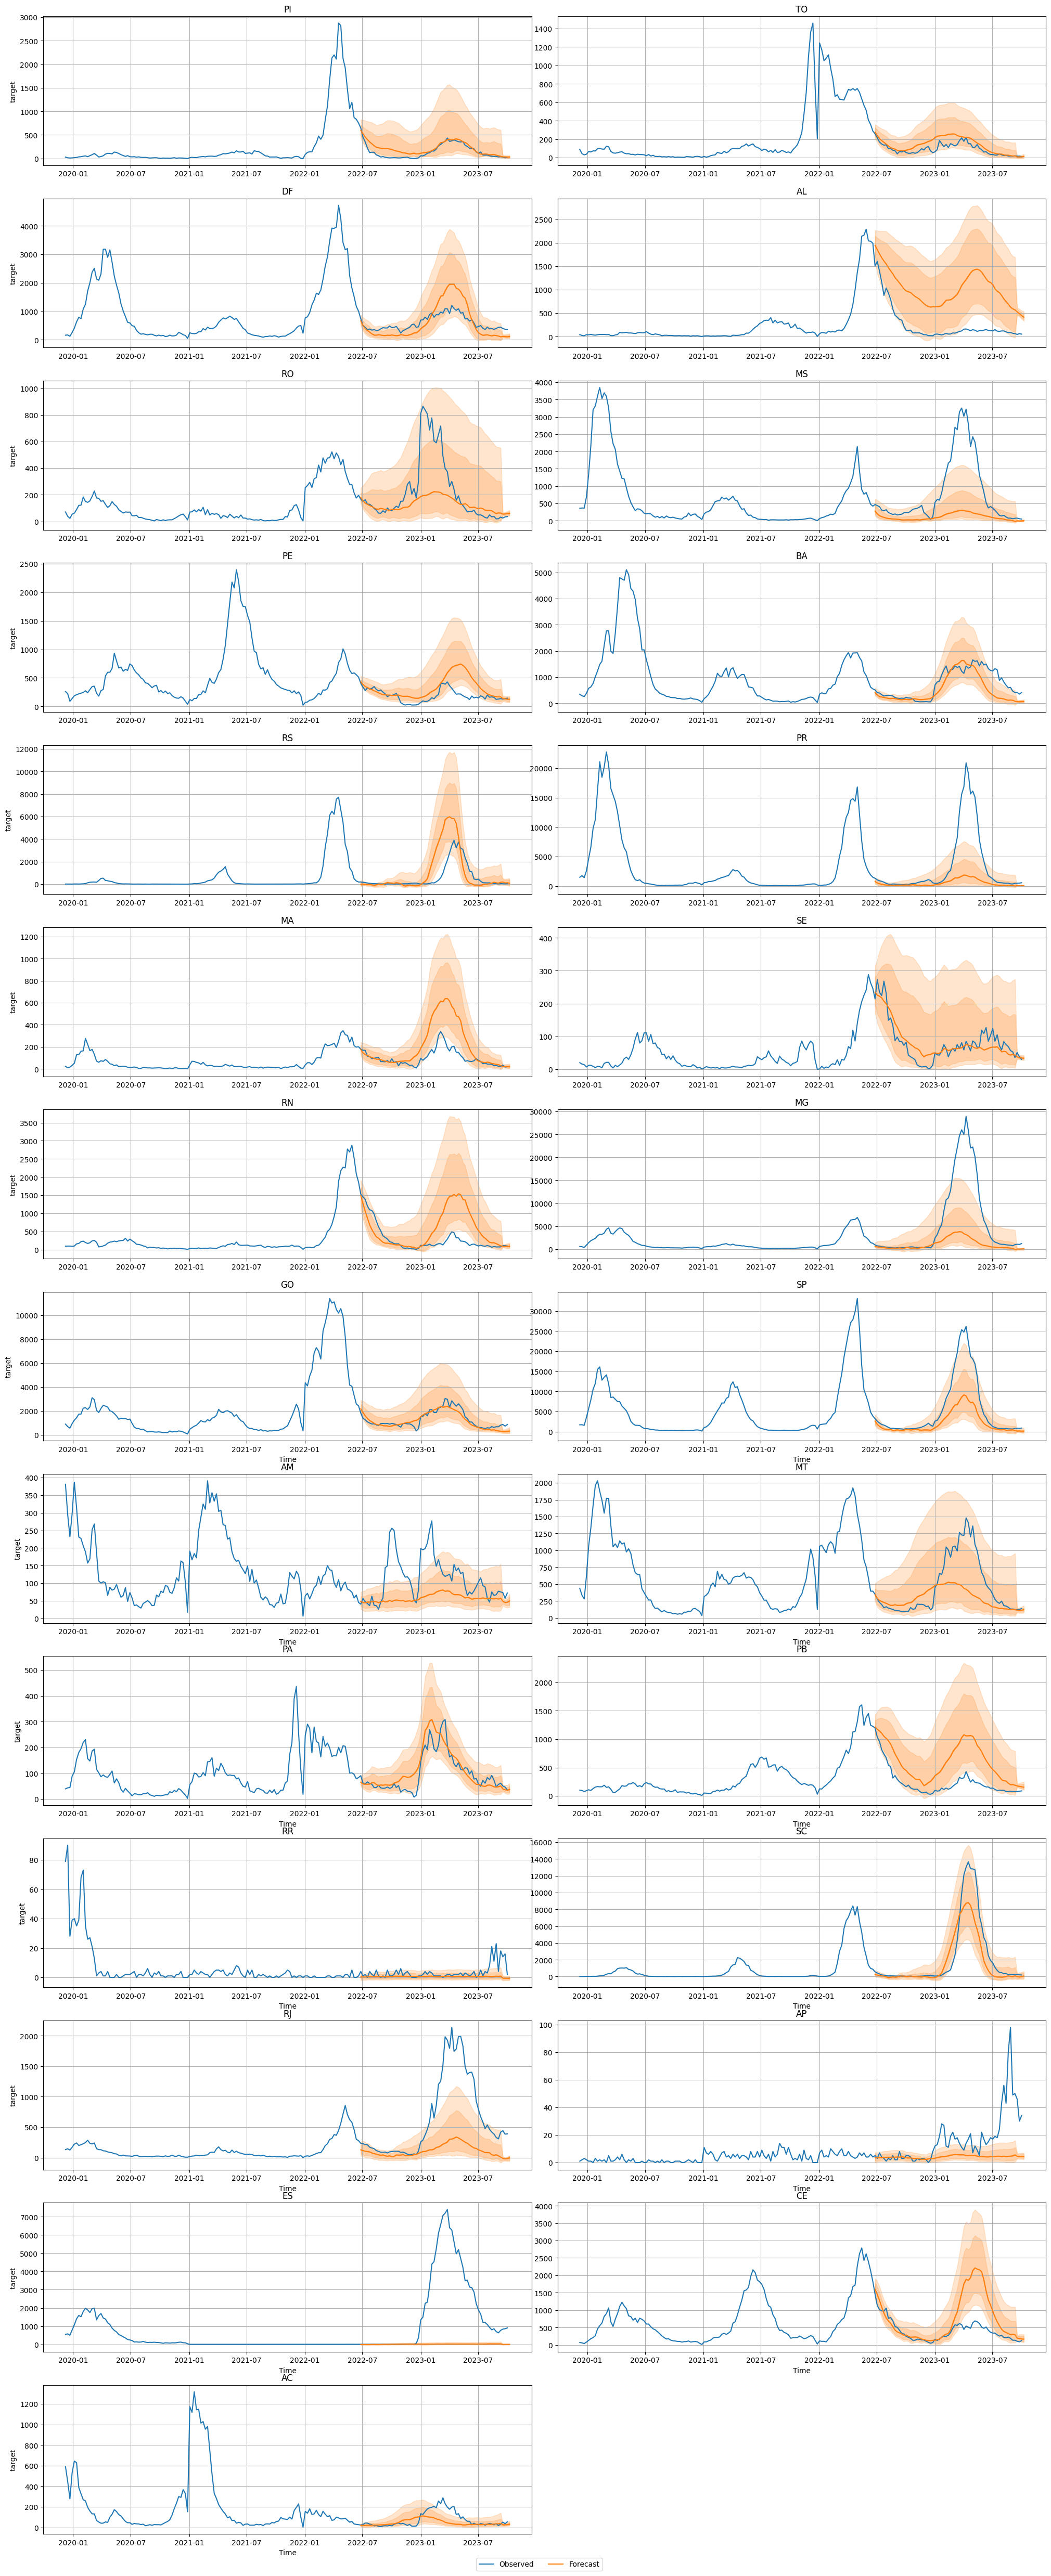

In [134]:
ufs = pd.unique(data['uf'])
predictor.plot(
    data=pd.concat([train_1,test_1]),
    quantile_levels=[0.1,0.2,0.5,0.8,0.9],
    # quantile_levels=[0.05,0.1,0.5,0.9,0.95],
    # quantile_levels= QS,
    predictions=predictions,
    # item_ids=['CE'],
    item_ids = ufs,
    max_num_item_ids=None,
    max_history_length=200,
)